# us-housing-prices-v2

https://www.dolthub.com/repositories/dolthub/us-housing-prices-v2/doc/main

The original data can be fetched with `dolt clone` (80GB or so) and then dumped into 10x smaller compressed parquet files that can directly be queries via ibis and duckdb.

```
dolt clone dolthub/us-housing-prices-v2
dolt dump -d us-housing-prices-v2-parquet -r parquet
```

In [1]:
import ibis

ibis.options.interactive = True
ibis.__version__

'3.2.0'

Create an empty duckdb database that we will populate with a subset of the parquet files:

In [2]:
db_name = "us-housing-prices-v2-subset.duckdb"

In [15]:
# !rm -f $db_name

In [16]:
con = ibis.duckdb.connect(db_name)

Register the parquet files as tables:

In [17]:
con.register("sales.parquet", table_name="sales")
con.register("states.parquet", table_name="states")
sales = con.table("sales")
states = con.table("states")

/Users/ogrisel/mambaforge/envs/dev/lib/python3.10/site-packages/duckdb_engine/__init__.py:229: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(
/Users/ogrisel/mambaforge/envs/dev/lib/python3.10/site-packages/duckdb_engine/__init__.py:229: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


Remove the buyer and saler names as there is at least one invalid UTF-8 value in those columns that makes duckdb crash whenever we access it:

In [20]:
sales = sales[[c for c in sales.columns if not c.endswith("_name")]]

In [21]:
sales.count()

100576630

In [33]:
sales

,state,property_zip5,property_street_address,property_city,property_county,property_id,sale_datetime,property_type,sale_price,building_num_units,...,land_assessed_date,seller_1_state,seller_2_state,buyer_1_state,buyer_2_state,total_assessed_value,total_appraised_value,land_appraised_value,building_appraised_value,land_type
0,AZ,85143,1 E CORAL BEAN DR,SAN TAN VALLEY,PINAL,210572230,2021-04-20,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
1,AZ,85143,1 E PEPPERGRASS PL,SAN TAN VALLEY,PINAL,210571490,2020-09-16,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
2,AZ,85173,1 N MESQUITE DR,SUPERIOR,PINAL,10526004A,2021-02-25,None,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
3,AZ,85143,1 W CANYON ROCK RD,SAN TAN VALLEY,PINAL,210702840,2011-09-01,RESIDENTIAL,90000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
4,AZ,85143,1 W MILL REEF DR,SAN TAN VALLEY,PINAL,210591110,2009-08-14,RESIDENTIAL,65000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AZ,85132,7416 N CORAZON DR,FLORENCE,PINAL,200696690,2018-06-13,None,7300000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9996,CA,None,1000 PINE 127N ST #1270,None,SAN FRANCISCO,0253T127N,2008-11-04,Timeshare,500,1.0,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9997,AZ,85142,33240 N CAT HILLS AVE,SAN TAN VALLEY,PINAL,509131460,2020-05-01,RESIDENTIAL,258000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9998,AZ,85122,1470 E,AVENIDA ISABELA CASA GRANDE,PINAL,505850160,2019-06-10,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None


In [34]:
%%time
sales.limit(100_000).info()

                                     Summary of Limit                                     
                                       100000 rows                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Name                     ┃ Type                                    ┃ # Nulls ┃ % Nulls ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ state                    │ String(nullable=True)                   │       0 │    0.00 │
│ property_zip5            │ String(nullable=True)                   │    1032 │    1.03 │
│ property_street_address  │ String(nullable=True)                   │       0 │    0.00 │
│ property_city            │ String(nullable=True)                   │    1031 │    1.03 │
│ property_county          │ String(nullable=True)                   │       0 │    0.00 │
│ property_id              │ String(nullable=True)                   │       0 │    0.00 │

In [35]:
sales.sale_price.min()

-2147483648

In [36]:
sales.sale_price.max()

70000199392

In [37]:
sales[sales.sale_price < 0].count()

998

In [38]:
sales[sales.sale_price > 0].count()

82457025

In [39]:
sales[sales.sale_price > 1_000_000_000].count()

384

In [40]:
import numpy as np

In [41]:
price_buckets = [0] + [10 ** i  for i in range(10)]
price_buckets

[0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]

In [42]:
price_bucket = sales.sale_price.bucket(
    price_buckets,
    include_under=True,
    include_over=True
).name("price_bucket")

price_counts = (
    price_bucket
    .to_projection()
    .group_by("price_bucket")
    .count()
    .sort_by("price_bucket")
)
price_counts

,price_bucket,count
0,0,998
1,1,18118607
2,2,4520234
3,3,1147676
4,4,5703754
5,5,2533709
6,6,18645967
7,7,45711685
8,8,3709217
9,9,459622


In [43]:
labeled_bucket = price_counts.price_bucket.label(
    [f'< ${int(threshold):,}' for threshold in price_buckets] + [f"> ${int(price_buckets[-1]):,}"]
).name('price_bucket_name')
expr = price_counts[labeled_bucket, price_counts].sort_by('price_bucket')
price_dist_df = expr.execute()
price_dist_df

,price_bucket_name,price_bucket,count
0,< $0,0,998
1,< $1,1,18118607
2,< $10,2,4520234
3,< $100,3,1147676
4,"< $1,000",4,5703754
5,"< $10,000",5,2533709
6,"< $100,000",6,18645967
7,"< $1,000,000",7,45711685
8,"< $10,000,000",8,3709217
9,"< $100,000,000",9,459622


In [44]:
sales.count().execute() == price_dist_df["count"].sum()

True

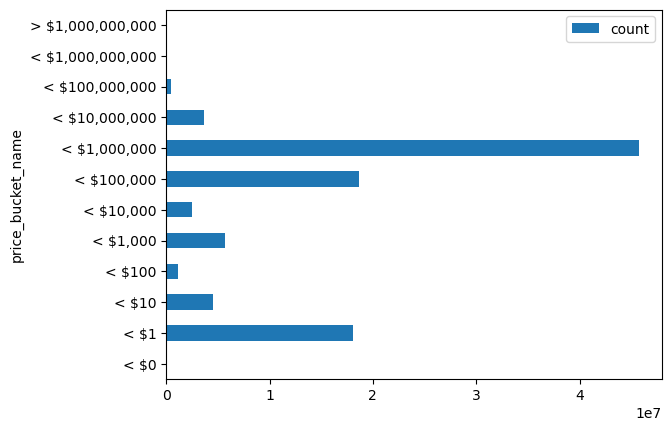

In [45]:
price_dist_df.plot.barh(x="price_bucket_name", y="count");

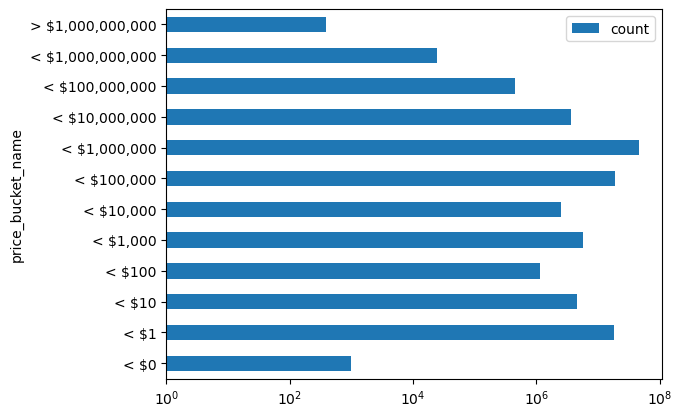

In [46]:
price_dist_df.plot.barh(x="price_bucket_name", y="count", log=True);

## Extracting a subset of the sales with non-missing building area info

In [49]:
sales[sales.building_area_sqft > 0].count()

14484775

Let's materialize the subset of the sales in a dedicated duckdb table.

In [50]:
%%time
con.create_table("sales_subset", sales[sales.building_area_sqft > 0])

CPU times: user 1min 8s, sys: 30.2 s, total: 1min 39s
Wall time: 2min 10s


In [63]:
ls -lh *.duckdb

-rw-r--r--  1 ogrisel  staff   1.5G Sep 27 12:17 us-housing-prices-v2-subset.duckdb


In [52]:
sales_subset = con.table("sales_subset")
sales_subset

,state,property_zip5,property_street_address,property_city,property_county,property_id,sale_datetime,property_type,sale_price,building_num_units,...,land_assessed_date,seller_1_state,seller_2_state,buyer_1_state,buyer_2_state,total_assessed_value,total_appraised_value,land_appraised_value,building_appraised_value,land_type
0,AZ,85143,1 E CORAL BEAN DR,SAN TAN VALLEY,PINAL,210572230,2021-04-20,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
1,AZ,85143,1 E PEPPERGRASS PL,SAN TAN VALLEY,PINAL,210571490,2020-09-16,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
2,AZ,85143,1 W CANYON ROCK RD,SAN TAN VALLEY,PINAL,210702840,2011-09-01,RESIDENTIAL,90000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
3,AZ,85143,1 W MILL REEF DR,SAN TAN VALLEY,PINAL,210591110,2009-08-14,RESIDENTIAL,65000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
4,AZ,85143,10 E MILL REEF DR,SAN TAN VALLEY,PINAL,210590970,2022-01-28,RESIDENTIAL,0,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AZ,85123,10153 W GRAYBACK DR,ARIZONA CITY,PINAL,407127300,2020-01-01,RESIDENTIAL,144000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9996,AZ,85139,21938 N SUNSET DR,MARICOPA,PINAL,512053790,2019-04-01,RESIDENTIAL,274900,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9997,AZ,85118,7502 E PALO BREA DR,GOLD CANYON,PINAL,108320460,2022-02-01,RESIDENTIAL,475000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None
9998,AZ,85123,14825 S COUNTRY CLUB DR,ARIZONA CITY,PINAL,408052220,1998-04-20,RESIDENTIAL,15000,NaN,...,NaT,None,None,None,None,NaN,NaN,NaN,NaN,None


In [54]:
sales_subset.count()

14484775

In [56]:
sales_subset.info()

                                  Summary of sales_subset                                  
                                       14484775 rows                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Name                     ┃ Type                                    ┃  # Nulls ┃ % Nulls ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ state                    │ String(nullable=True)                   │        0 │    0.00 │
│ property_zip5            │ String(nullable=True)                   │  4089280 │   28.23 │
│ property_street_address  │ String(nullable=True)                   │        0 │    0.00 │
│ property_city            │ String(nullable=True)                   │  1789213 │   12.35 │
│ property_county          │ String(nullable=True)                   │    14076 │    0.10 │
│ property_id              │ String(nullable=True)                   │  1686164 

In [69]:
building_area_sqft_values = sales_subset[sales_subset.building_area_sqft].limit(int(1e12)).execute()
building_area_sqft_values.describe()

,building_area_sqft
count,1.448478e+07
mean,2.403155e+03
std,9.371600e+03
min,1.000000e+00
25%,1.248000e+03
50%,1.712000e+03
75%,2.454000e+03
max,4.204820e+06


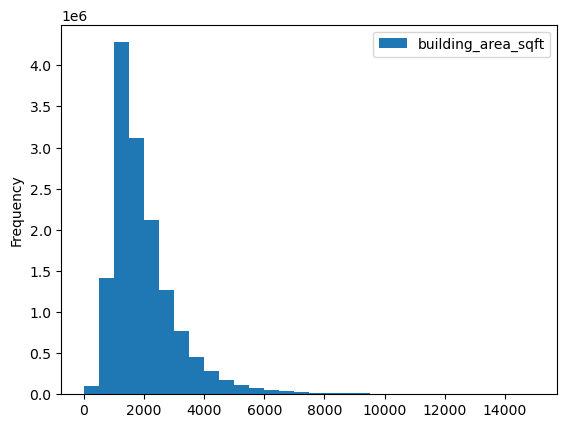

In [73]:
building_area_sqft_values.query("building_area_sqft < 15000").plot.hist(bins=30);

### The `states` file 

In [55]:
statesplot.hist(bins=30)

,code,name
0,LA,Louisiana
1,MA,Massachusetts
2,MD,Maryland
3,DE,Delaware
4,FL,Florida
5,FM,Federated States of Micronesia
6,ME,Maine
7,MH,Marshall Islands
8,MI,Michigan
9,CO,Colorado
